Init Plugin
Init Graph Optimizer
Init Kernel
shapes od the dataset:
(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


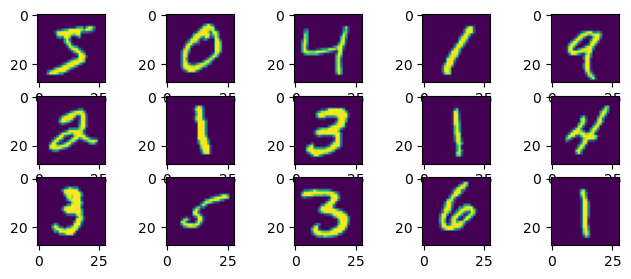

In [1]:
import numpy as np
# only for the dataset :)
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
from IPython import display

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train/255, axis =1)
x_test = np.expand_dims(x_test/255, axis =1)

print('shapes of the dataset:')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


nrows, ncols = (3, 5)
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 3))

filters =[x_train[i][0] for i in range(nrows * ncols)]

for i, data in enumerate(filters):
  ax[i // ncols, i % ncols].imshow(data)


In [2]:
# without batch size
def training_loop(model, loss_function, x_train, y_train, itterations):
    model.Train()
    assert x_train.shape[0]== y_train.shape[0], f'dataset and targets are not the same lenght'
    losses = []
    for i in range(itterations):
        print(i)
        idx = np.random.choice(x_train.shape[0], size=1)
        x = x_train[idx].squeeze(axis=0)
        y = y_train[idx]
    
        # forward
        x = model.forward(x)
        loss = loss_function.get_loss(x, y)
        losses.append(loss)
        
        # backward
        next_errors = loss_function.backward()
        _ = model.backward(next_errors)
        
        # plot losses
        display.clear_output(wait=True)
        plt.plot(losses, label='Loss (inc loss weights)')
        plt.xlabel('Itterations')
        plt.ylabel('Loss')
        plt.title('Training Loss at itteration %d' %(i+1))
        plt.legend()
        plt.show()
        
    return losses    

In [3]:
# define model
import Layers
from Sequential import sequential
from optimizer_and_loss_function import Adam_optimizer, Categorical_cross_entropy_loss

mnist_model = sequential([
                            Layers.Conv2d_max_Cin((1,28,28), 5, kernel=(5, 5), strides=(1,1)),
                            Layers.ReLu(), 
                            Layers.MAXpool((5, 24, 24), kernel=(2,2), strides=(2,2)),
                            Layers.Conv2d_max_Cin((5,12,12), 10, kernel=(3, 3), strides=(1,1)),
                            Layers.ReLu(), 
                            Layers.MAXpool((10, 10, 10), kernel=(2,2), strides=(2,2)),
                            Layers.Reshape((10,5,5),(250)),
                            Layers.Linear(250, 10),
                            Layers.Softmax(10)
                        ]) 
mnist_model.Train()
optimizer = Adam_optimizer(LR=0.1, B_1=0.9 , B_2=0.999, weight_decay=0.001)
mnist_model.Optimizer(optimizer)
loss_function = Categorical_cross_entropy_loss(10)

idx = np.random.choice(x_train.shape[0], size=1)
x = x_train[idx].squeeze(axis=0)
y = y_train[idx]

out = mnist_model.forward(x)
print(out)
loss = loss_function.get_loss(out, y)
print(loss)
next_errors = loss_function.backward()

out = mnist_model.backward(next_errors)
#print(out)
#optimizer = Adam_optim()
#mnist_model.optimizer(optimizer)

[0.08956768 0.08442609 0.10194219 0.08348042 0.11379959 0.09368596
 0.1224772  0.10431676 0.09802774 0.10827638]
2.4718788493264454


/Users/freeklinssen/coding/MNIST_in_numpy/Layers.py:342: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  dloss_dMUs = (next_error * (-1/self.SIGMAs) + dloss_dVARs*((-2(self.input-self.MUs))/2))


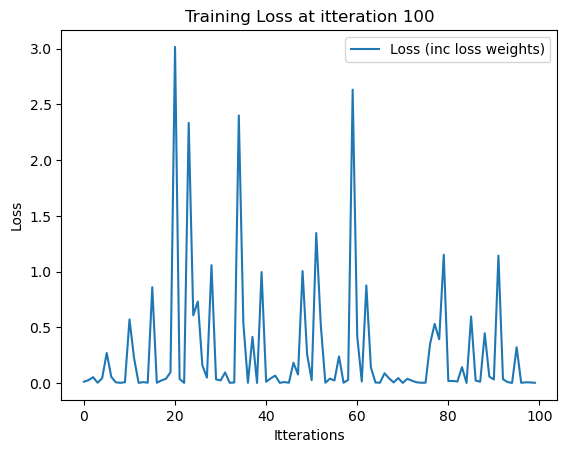

In [29]:
# Full training loop to achieve 90% accuracy:

optimizer = Adam_optimizer(LR=0.1, B_1=0.9 , B_2=0.999, weight_decay=0.001)
mnist_model.Optimizer(optimizer)
losses = training_loop(mnist_model, loss_function, x_train, y_train, 1000)

optimizer = Adam_optimizer(LR=0.01, B_1=0.9 , B_2=0.999, weight_decay=0.0001)
mnist_model.Optimizer(optimizer)
losses = training_loop(mnist_model, loss_function, x_train, y_train, 1000)

In [45]:
mnist_model.Eval()

incorrect = 0
for i in range(5000):
    x = x_test[[i]].squeeze(axis=0)
    y = y_test[i]
    out = mnist_model.forward(x)
    out = out.argmax()
    print(out, y)
    if out != y:
        incorrect+=1
        
accuracy = ((5000-incorrect)/5000)*100
print(f'out of sample accuracy: {accuracy}%')

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9
0 0
6 6
9 9
0 0
1 1
3 5
9 9
7 7
3 3
4 4
9 9
6 6
6 6
5 5
4 4
0 0
7 7
4 4
0 0
1 1
3 3
1 1
3 3
2 4
7 7
2 2
7 7
1 1
2 2
1 1
1 1
7 7
4 4
2 2
3 3
5 5
1 1
2 2
4 4
4 4
6 6
3 3
5 5
3 5
6 6
0 0
4 4
1 1
9 9
7 5
7 7
8 8
9 9
3 3
7 7
4 4
0 6
4 4
3 3
0 0
7 7
0 0
2 2
9 9
1 1
7 7
3 3
7 2
9 9
7 7
7 7
6 6
2 2
7 7
5 8
4 4
7 7
3 3
6 6
1 1
3 3
6 6
9 9
3 3
1 1
4 4
1 1
7 7
6 6
9 9
6 6
0 0
5 5
4 4
9 9
9 9
2 2
1 1
9 9
4 4
8 8
7 7
3 3
9 9
7 7
4 4
4 4
4 4
9 9
7 2
5 5
4 4
7 7
6 6
4 7
9 9
0 0
5 5
8 8
5 5
6 6
6 6
5 5
7 7
8 8
1 1
0 0
1 1
6 6
4 4
6 6
7 7
2 3
1 1
7 7
1 1
8 8
2 2
0 0
2 2
9 9
2 9
5 5
5 5
1 1
5 5
6 6
0 0
3 3
4 4
4 4
6 6
5 5
4 4
6 6
5 5
4 4
4 5
1 1
4 4
4 4
7 7
2 2
3 3
2 2
7 7
1 1
8 8
1 1
8 8
1 1
8 8
5 5
0 0
8 8
9 9
2 2
3 5
0 0
1 1
1 1
1 1
0 0
3 9
0 0
4 3
1 1
6 6
4 4
2 2
3 3
6 6
1 1
1 1
1 1
3 3
9 9
3 5
2 2
9 9
4 4
5 5
9 9
3 3
9 9
0 0
3 3
5 6
5 5
5 5
7 7
2 2
2 2
7 7
1 1
2 2
8 8
4 4
1 1
7 7
3 3
3 3
8 8
7 8
7 7
9 9
2 2
2 2
4 4
1 1
5 5
3 9
8 8
9 7
2 2
3 3
0 0
2 4
4 4
2 2


In [48]:
print(np.random.uniform(-5, 5, ))

-3.554835587319072


In [43]:
test = np.arange(0,200).reshape((2,10,10))
file = 'weights/test.npy'
np.save(file, test)

test = np.load(file)

# Suppose weights is a dictionary containing your weight arrays
test_2 = np.arange(0,20).reshape((2,10))
weights = {
    'layer1_weights': test,
    'layer1_biases': test_2,
}

# Save the weights to a file
np.savez('weights/weights.npz', **weights)
out = np.load('weights/weights.npz')

layer1_weights = out['layer1_weights']
layer1_biases = out ['layer1_biases']
print(layer1_weights)
print(layer1_biases)

[[[  0   1   2   3   4   5   6   7   8   9]
  [ 10  11  12  13  14  15  16  17  18  19]
  [ 20  21  22  23  24  25  26  27  28  29]
  [ 30  31  32  33  34  35  36  37  38  39]
  [ 40  41  42  43  44  45  46  47  48  49]
  [ 50  51  52  53  54  55  56  57  58  59]
  [ 60  61  62  63  64  65  66  67  68  69]
  [ 70  71  72  73  74  75  76  77  78  79]
  [ 80  81  82  83  84  85  86  87  88  89]
  [ 90  91  92  93  94  95  96  97  98  99]]

 [[100 101 102 103 104 105 106 107 108 109]
  [110 111 112 113 114 115 116 117 118 119]
  [120 121 122 123 124 125 126 127 128 129]
  [130 131 132 133 134 135 136 137 138 139]
  [140 141 142 143 144 145 146 147 148 149]
  [150 151 152 153 154 155 156 157 158 159]
  [160 161 162 163 164 165 166 167 168 169]
  [170 171 172 173 174 175 176 177 178 179]
  [180 181 182 183 184 185 186 187 188 189]
  [190 191 192 193 194 195 196 197 198 199]]]
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]]


In [58]:
import os

model ='first_model'
id=1
layer_id = f'{id}.npz'
path = os.path.join(model, layer_id)
print(path)

first_model/1.npz


In [10]:
import numpy as np
import Layers
from Sequential import sequential
from optimizer_and_loss_function import Adam_optimizer, Categorical_cross_entropy_loss

test = np.arange(0,400).reshape((4,10,10)) 
layer = Layers.Conv2d((4,10,10), 5, kernel=(2, 2), strides=(1,1))

out = layer.forward(test)
out = layer.backward(out)
print(out.shape)

(4, 10, 10)


In [1]:
b = np.array([[[1, 1, 1, 1]],
              [[2,2,2,2]]])

c = np.array([[[1],
              [3],
              [2],
              [1]],
             [[2],
              [2],
              [2],
              [2]]])

print(c.shape)
print(b.shape)

print(np.dot(b[1],c[1]))
#print(np.tensordot(c,b, axes=(2,1)))
#print(np.tensordot(c,b, axes=(-1)).shape)


print('oke')
print(np.einsum('ijk,ikl->ijl', c, b, optimize = True))

print(np.einsum('ikj,ilk->ijl', b, c, optimize = True))


NameError: name 'np' is not defined

In [153]:
b = np.array([[[2,2,2,2]]])

c = np.array([[[2],
              [2],
              [2],
              [2]]])

print(c.shape)
print(b.shape)




#print(np.tensordot(c,b, axes=(2,1)))
#print(np.tensordot(c,b, axes=(-1)).shape)


print('oke')
print(np.einsum('ijk,ijl->ijl', c, b, optimize = True))

(1, 4, 1)
(1, 1, 4)
oke
[[[4 4 4 4]
  [4 4 4 4]
  [4 4 4 4]
  [4 4 4 4]]]


In [34]:
import numpy as np

img = np.arange(0,200)
img = img.reshape((2,10,10))
#map=np.zeros((2,10,10))
in_channels = 2
img_hw=(10, 10) 
kernel=(2, 2) 
strides=(2, 2)
print((img_hw[0]+(strides[0]-kernel[0])) % strides[0])
assert (img_hw[0]+(strides[0]-kernel[0])) % strides[0] == 0,f'kernel and stride do not match this image shape'
assert (img_hw[1]+(strides[1]-kernel[1])) % strides[1] == 0,f'these kernel and stride do match fit this image shape'
        
steps_hw = [(i+(s-k))//s for i,s,k in zip(img_hw, strides, kernel)]
print(steps_hw)

tmp = [(0,o*s)for o, s in zip(steps_hw, strides)]
#print(tmp)

img_tmp =(2,2,10,10)

slc_prefix = tmp+[(0,x) for x in img_tmp[0:-len(kernel)]]
#print(slc_prefix)

H_keys = np.zeros((in_channels, steps_hw[0]*steps_hw[1], kernel[0], img_hw[0]))
W_keys = np.zeros((in_channels, steps_hw[0]*steps_hw[1], img_hw[1], kernel[1]))


for c in range(in_channels):
    for h in range(steps_hw[0]):
        h_tmp = np.zeros((kernel[0], img_hw[0]))
        h_tmp[([i for i in range(kernel[0])]), ([(h*strides[0])+i for i in range(kernel[0])])] = 1
        for w in range(steps_hw[1]):
            w_tmp = np.zeros((img_hw[1], kernel[1]))
            w_tmp[([(w*strides[1])+i for i in range(kernel[1])]), ([i for i in range(kernel[1])])] = 1
            H_keys[c,h*steps_hw[1]+w] = h_tmp
            W_keys[c,h*steps_hw[1]+w] = w_tmp

#print(W_keys[1,3])
img = np.repeat(np.expand_dims(img, -3), steps_hw[0]*steps_hw[1], axis=-3)
# input is now of shape (channels, n, H, W), the same as the self.H and self.w
out = np.einsum('ijkl,ijlm-> ijkm', H_keys, img, optimize = True)
out = np.einsum('ijkl,ijlm-> ijkm', out, W_keys, optimize = True)

max_mask = np.zeros((in_channels, steps_hw[0]*steps_hw[1], kernel[0]*kernel[1]))
max_mask[..., np.argmax(out.reshape((in_channels, steps_hw[0]*steps_hw[1], kernel[0]*kernel[1])), axis=-1)] = 1
max_mask = max_mask.reshape((in_channels, steps_hw[0]*steps_hw[1], kernel[0], kernel[1]))
out = out.max(axis=-1).max(axis=-1) 
out = out.reshape((in_channels, steps_hw[0], steps_hw[1]))   
print(out)

next_errors = np.tile(out.reshape(in_channels, steps_hw[0]*steps_hw[1], 1, 1), (1, 1, kernel[0], kernel[1]))
next_errors = next_errors * max_mask

next_errors = np.einsum('ijkl,ijlm-> ijkm', next_errors, np.transpose(W_keys, axes=(0,1,3,2)), optimize = True)
next_errors = np.einsum('ijkl,ijlm-> ijkm', np.transpose(H_keys, axes=(0,1,3,2)), next_errors, optimize = True)
        
print(next_errors.sum(axis=-3))
 
     


0
[5, 5]
[[[ 11.  13.  15.  17.  19.]
  [ 31.  33.  35.  37.  39.]
  [ 51.  53.  55.  57.  59.]
  [ 71.  73.  75.  77.  79.]
  [ 91.  93.  95.  97.  99.]]

 [[111. 113. 115. 117. 119.]
  [131. 133. 135. 137. 139.]
  [151. 153. 155. 157. 159.]
  [171. 173. 175. 177. 179.]
  [191. 193. 195. 197. 199.]]]
[[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.  11.   0.  13.   0.  15.   0.  17.   0.  19.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.  31.   0.  33.   0.  35.   0.  37.   0.  39.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.  51.   0.  53.   0.  55.   0.  57.   0.  59.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.  71.   0.  73.   0.  75.   0.  77.   0.  79.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.  91.   0.  93.   0.  95.   0.  97.   0.  99.]]

 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0. 111.   0. 113.   0. 115.   0. 117.   0. 119.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.

In [410]:
print((1,1)+(1,1))

a = np.array([[1,2,3,4]])
a = np.tile(a.reshape(1, 4, 1, 1), (1, 1, 3, 3))

b = np.array([[1,2,3,4]])
b = np.tile(b.reshape(1, 4, 1, 1), (1, 1, 3, 3))
print((a*b))

print(np.repeat(np.expand_dims(a,0), 4, axis=0).shape)

(1, 1, 1, 1)
[[[[ 1  1  1]
   [ 1  1  1]
   [ 1  1  1]]

  [[ 4  4  4]
   [ 4  4  4]
   [ 4  4  4]]

  [[ 9  9  9]
   [ 9  9  9]
   [ 9  9  9]]

  [[16 16 16]
   [16 16 16]
   [16 16 16]]]]
(4, 1, 4, 3, 3)


In [446]:
#pooled should be in shape (n, C_in, H.k, W.k)
#self.weight in shape (C_out, H,K, W,k)
pooled= np.arange(0, (20*5*9)).reshape((20, 5, 3, 3))
#pooled = np.ones((20, 5, 3, 3))

weights = np.ones((2, 3, 3))
weights = np.expand_dims(weights, axis=(1,2))

print(weights.shape)
multiplied = pooled*weights
print(multiplied.shape)

max_pooled = multiplied.sum(axis=-1).sum(axis=-1)
print(max_pooled.shape)
# Find the indices of the maximum values along the last axis
values = max_pooled.max(axis=-1)
# Access the maximum values using the indices
idxs = np.argmax(max_pooled, axis=-1)

result = multiplied[np.expand_dims(np.arange(max_pooled.shape[0]),-1), np.expand_dims(np.arange(max_pooled.shape[1]), 0), idxs]
print(result.shape)

mask = np.zeros(multiplied.shape)
mask[np.expand_dims(np.arange(max_pooled.shape[0]),-1), np.expand_dims(np.arange(max_pooled.shape[1]), 0), idxs] =1
next_errors = mask*multiplied
print(next_errors.shape)
next_errors = next_errors.transpose(2,1,0,3,4).sum(axis=-3)
print(next_errors.shape)

(2, 1, 1, 3, 3)
(2, 20, 5, 3, 3)
(2, 20, 5)
(2, 20, 3, 3)
(2, 20, 5, 3, 3)
(5, 20, 3, 3)


In [430]:
exmp = np.array([[0,0,0,0,0],
                [0,1,2,3,0],
                [0,4,5,6,0],
                [0,7,8,9,0]])

hightM = np.array([[0,1,0,0],
                   [0,0,1,0],
                   [0,0,0,1]])

widthM = np.array([[0,0,0],
                   [1,0,0],
                   [0,1,0],
                   [0,0,1],
                   [0,0,0]])

small = hightM.dot(exmp).dot(widthM)
print(small)
large = hightM.T.dot(small.dot(widthM.T))
print(large)


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]]


In [445]:
tmp =np.zeros((3, 5))
tmp[(0,1,2), (1, 1+1, 1+2)] = 1
print(tmp)

[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [6]:
# Assuming x is your input tensor with shape (batch, channels, 10, 10)
input = np.arange((300)).reshape((3, 4, 5, 5))
weights = np.arange((100)).reshape((4, 5, 5))

input[0,0,0,1] = 20

print(input[0,0,0,1])

# Reshape to (batch * 5, 10, 10) to treat each channel as a separate 'image'
#x_reshaped = x.reshape(batch_size * num_channels, height, width)
#x = x.transpose(1,0,2,3)

# Calculate mean and standard deviation across the reshaped channels
mean = np.mean(input, axis=0)
print(mean.shape)
std = np.std(input, axis=0)
print(std.shape)


#print(input-mean)
normalized_x = (input-mean)/std
print(normalized_x.shape)
print(normalized_x[0,0,0])
print(normalized_x[2,3,4])


next_error = normalized_x  #np.arange((300)).reshape((3, 4, 5, 5))
#next_error[0,0,0,1] = -1.18
#next_error = error*weights
#print(next_error)

# not really a good wat to check if this works propperly
dloss_dVARs = next_error * (input-mean) * (-1/2) * (np.power(std, -3))
dloss_dMUs = next_error * (-1/std) + dloss_dVARs*((-2*(input-mean))/2)   
next_error = next_error*(1/std) + dloss_dVARs*(2*(input-mean)/input.shape[0]) + dloss_dMUs/input.shape[0]

print(next_error.shape)
print(next_error)

20
(4, 5, 5)
(4, 5, 5)
(3, 4, 5, 5)
[-1.22474487 -1.17972546 -1.22474487 -1.22474487 -1.22474487]
[1.22474487 1.22474487 1.22474487 1.22474487 1.22474487]
(3, 4, 5, 5)
[[[[-0.00625    -0.00692755 -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]]

  [[-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]]

  [[-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625    -0.00625   ]
   [-0.00625    -0.00625    -0.00625    -0.00625

Testing

In [1]:
import numpy as np
from Layers import Linear


input = np.ones((4))*2
print(input)
linear = Linear(4,2)
out = linear.forward(input)
print(out)


next_error = linear.backward(out)
print(next_error)

# the linear layer in implemented in the rightly

[2. 2. 2. 2.]
[0.01977055 0.00442295]
[-1.82161456e-04 -7.24131148e-05  7.47749829e-05  3.08936620e-04]


/Users/freeklinssen/coding/MNIST_in_numpy/Layers.py:343: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  dloss_dMUs = (next_error * (-1/self.SIGMAs) + dloss_dVARs*((-2(self.input-self.MUs))/2))


In [2]:
# Test MAX Pool
import numpy as np
from Layers import pool, MAXpool

maxpool = MAXpool((2,10,10), kernel=(2, 2), strides=(1,1))

input = np.arange(0,200).reshape((2,10,10))
print(input[0])
out = maxpool.forward(input)
#print(out)
out= maxpool.backward(out)
print(out)

# and it works!

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.  11.  12.  13.  14.  15.  16.  17.  18.  19.]
  [  0.  21.  22.  23.  24.  25.  26.  27.  28.  29.]
  [  0.  31.  32.  33.  34.  35.  36.  37.  38.  39.]
  [  0.  41.  42.  43.  44.  45.  46.  47.  48.  49.]
  [  0.  51.  52.  53.  54.  55.  56.  57.  58.  59.]
  [  0.  61.  62.  63.  64.  65.  66.  67.  68.  69.]
  [  0.  71.  72.  73.  74.  75.  76.  77.  78.  79.]
  [  0.  81.  82.  83.  84.  85.  86.  87.  88.  89.]
  [  0.  91.  92.  93.  94.  95.  96.  97.  98.  99.]]

 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
  [  0. 121. 122. 1

In [3]:
# test convolution
import numpy as np
from Layers import Conv2d

convolution = Conv2d((2,10,10), 4, kernel=(2, 2), strides=(2,2))

input = np.arange(0,200).reshape((2,10,10))
#print(input[1])
out = convolution.forward(input)
print(out[0])
out= convolution.backward(out)
print(out)


# works correctly

(25, 2, 2, 2)
[[422. 430. 438. 446. 454.]
 [502. 510. 518. 526. 534.]
 [582. 590. 598. 606. 614.]
 [662. 670. 678. 686. 694.]
 [742. 750. 758. 766. 774.]]
(4, 2, 2)
[[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]

 [[1688. 1688. 1720. 1720. 1752. 1752. 1784. 1784. 1816. 1816.]
  [1688. 1688. 1720. 1720. 1752. 1752. 1784. 1784. 1816. 1816.]
  [2008. 2008. 2040. 2040. 2072. 2072. 2104. 2104. 2136. 2136.]
 

In [2]:
# test ReLu and Softmax
import numpy as np
from Layers import ReLu, Softmax

input = np.arange(-50, 150).reshape((2,10,10))

relu = ReLu()
out = relu.forward(input)
errors = np.arange(-50, 150).reshape((2,10,10))
out = relu.backward(errors)


input = np.arange(0, 10).reshape((10))
softmax = Softmax(10)
out = softmax.forward(input)
print(out)
out = softmax.backward(out)
print(out)



12818.308050524603
[7.80134161e-05 2.12062451e-04 5.76445508e-04 1.56694135e-03
 4.25938820e-03 1.15782175e-02 3.14728583e-02 8.55520989e-02
 2.32554716e-01 6.32149258e-01]
[-3.60485256e-05 -9.79616253e-05 -2.66077259e-04 -7.21720929e-04
 -1.95037271e-03 -5.21692370e-03 -1.35549277e-02 -3.22195211e-02
 -5.33955868e-02  1.07459140e-01]


In [9]:
# next: making the full model work, make the loss function, and load the data

True


In [29]:
def sparse_categorical_crossentropy(out, Y):
  num_classes = out.shape[-1]
  YY = Y.flatten()
  y = np.zeros((YY.shape[0], num_classes), np.float32)
  # correct loss for NLL, torch NLL loss returns one per row
  y[range(y.shape[0]),YY] = -1.0*num_classes
  print(y) 
  return (out * y).mean()

out = np.arange(0, 50).reshape((5,10))
Y = np.array([1,2,3,4,5])
#sparse_categorical_crossentropy(out, Y)

[[  0. -10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -10.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -10.   0.   0.   0.   0.]]
[5]


-23.0

In [1]:
# test cross entropy loss:
import numpy as np
from Layers import Categorical_cross_entropy_loss


input = np.arange(0, 20).reshape((2,10))
Y = np.array([0,1])
print(input)
loss_function = Categorical_cross_entropy_loss(10)
loss = loss_function.get_loss(input, Y)
print(loss)
next_error = loss_function.backward(loss)
print(next_error)

# and it works


[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]]
2.3025850929940455
[[-100.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.]
 [  -0.   -1.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.]]


/Users/freeklinssen/coding/MNIST_in_numpy/Layers.py:343: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  dloss_dMUs = (next_error * (-1/self.SIGMAs) + dloss_dVARs*((-2(self.input-self.MUs))/2))


In [ ]:
# with batch size 
def training_loop(model, loss_function, x_train, y_train, itterations, batch_size):
    model.Train()
    assert x_train.shape[0]== y_train.shape[0], f'dataset and targets are not the same lenght'
    
    losses = []
    for i in tqdm(range(itterations)):
        batch_idxs = np.random.choice(x_train.shape[0], size=batch_size)
        x_batch = x_train[batch_idxs] 
        y_batch = y_train[batch_idxs]
        print(x_batch.shape)
        print(y_batch.shape)
        
        # forward
        x_batch = model.forward(x_batch)
        loss = loss_function.get_loss(x_batch, y_batch)
        losses.append(loss)
        
        # backward
        next_errors = loss_function.backward()
        _ = model.backwards(next_errors)
    return losses
loop = training_loop(x_train, y_train,1, 5)